In [1]:
from pyquil.quil import *
from pyquil.api import get_qc
from pyquil.gates import *
from pyquil.latex import display, to_latex
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [2]:
from functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
qc = get_qc("9q-square-qvm")

ConnectError: [WinError 10061] No connection could be made because the target machine actively refused it

# Programmable recipe
![alt text](rotation_definition.png "Title")
$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})$$
![alt text](programmble_decomposition.png "Title")

In [ ]:
# program_unitary(G, n_qubits=2)

$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})\\
U(2) = R(\theta, \phi) R_z(\phi_z)\\
or\\
U(2) = R_z(\theta) R_y(\phi) R_z(\psi)
$$

In [6]:
G = Program( CPHASE01(-np.pi/2, control=0, target=1), CPHASE10(-np.pi/2, control=0, target=1) )

In [8]:
sample = give_random_two_qubit_circuit([0,1])
# print( qc.compile( sample ) , len(sample), len(qc.compile( sample )))

In [9]:
program_unitary(G, n_qubits=2)

array([[1.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 6.123234e-17-1.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 6.123234e-17-1.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        1.000000e+00+0.j]])

# Visualization
## single-qubit

In [ ]:
num_samples = 2021

single_qubit_unitary_samples = [program_unitary(give_random_single_qubit_gate(qubit=0), n_qubits = 1) for _ in range(num_samples)]

In [ ]:
single_zero_state_density_matrix = np.array([[1,0],[0,0]]) #|0><0| state
# What is U|0><0|U^T
single_final_states = np.array( [np.dot( np.dot(u,single_zero_state_density_matrix), u.conj().T ) for u in single_qubit_unitary_samples] )

In [14]:
# lets see where U|0><0|U^T is likely found
single_qubit_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in single_final_states])

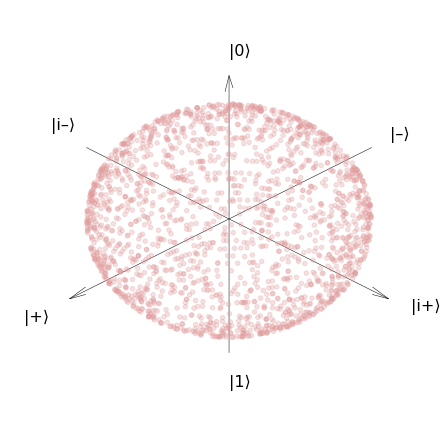

In [15]:
plot_bloch_sphere(single_qubit_bloch_vectors)

## Two qubits

In [ ]:
num_samples = 2021

two_qubit_unitary_samples = [program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits = 2) for _ in range(num_samples)]

In [ ]:
two_zero_state_density_matrix = np.kron( np.array([[1,0],[0,0]]) , np.array([[1,0],[0,0]]) )
two_final_states = np.array( [np.dot( np.dot(u,two_zero_state_density_matrix), u.conj().T ) for u in two_qubit_unitary_samples] )

In [ ]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

two_qubit_unitary_basis = np.array([ [ np.kron(x,y) for x in [X,Y,Z] ] for y in [X,Y,Z] ])
# two_qubit_unitary_basis[0]

In [ ]:
# Used the mixed state simulator so we could have the density matrix for this part!
def reduce_to_bloch_vector(rho, sigma_arr:np.array):
    """Reduce a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, sigma_arr[0])).real
    ay = np.trace(np.dot(rho, sigma_arr[1])).real
    az = np.trace(np.dot(rho, sigma_arr[2])).real
    return [ax, ay, az]

In [ ]:
two_qubit_bloch_vectors = np.array([reduce_to_bloch_vector(s,two_qubit_unitary_basis[2]) for s in two_final_states])
plot_bloch_sphere(two_qubit_bloch_vectors)

### Verification of Haar distribution
we need to find out whether the distribution of the points is really uniform over the total space. To do so we first compute the radial distance of points and plot their cumulative histogram. If it grows with the power of 3 then we can be sure that the density of points is uniform in the sphere.

In [ ]:
r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)

In [ ]:
n_bins = 10

fig, ax = plt.subplots()

bins = np.logspace(np.log10(0.1),np.log10(1),n_bins)
# plot the cumulative histogram
pop, bins, hist_ = ax.hist( r_bloch_vectors, bins, histtype='step',
                           cumulative=True, density = True, label='Empirical')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.plot(np.linspace(0,1,10), np.linspace(0,1,10)**slope)
ax.plot(bins, bins**3)
plt.show()


In [ ]:
non_zero_mask = pop != 0
regression_pop = pop[non_zero_mask]
regression_bins = np.array( bins[:-1] ) [non_zero_mask]
exp, intercept = np.polyfit(np.log(regression_bins), np.log(regression_pop), deg = 1)
exp, intercept

In [ ]:
def exponent_of_dist(data):
    n_bins = 100
    bins = np.logspace(np.log10(0.1),np.log10(1),n_bins)
    # plot the cumulative histogram
    pop, bins, hist_ = plt.hist( data, bins, cumulative=True, density = True)
    # extrapolate the exponent
    non_zero_mask = pop != 0
    regression_pop = pop[non_zero_mask]
    regression_bins = np.array( bins[:-1] ) [non_zero_mask]
    exp, intercept = np.polyfit(np.log(regression_bins), np.log(regression_pop), deg = 1)
    plt.close()
    return exp

In [ ]:
exp_list = []
for i in range(len(two_qubit_unitary_basis)):
    two_qubit_bloch_vectors = np.array([reduce_to_bloch_vector(s,two_qubit_unitary_basis[i]) for s in two_final_states])
    r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)
    exp_list.append(exponent_of_dist(r_bloch_vectors))
exp_list

# Matrix decomposition verification


In [4]:
from scipy.stats import unitary_group
import cmath

In [5]:
lambda_unitary = np.array([ [1, 1j , 0 , 0],[0, 0, 1j, 1],[0, 0, 1j, -1],[1, -1j, 0, 0] ]) / np.sqrt(2)
cnot_arr = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [6]:
def give_v_circuit(alpha, beta, delta, qubits = [0,1]):
    prog = Program(CNOT(control=qubits[1], target=qubits[0]),
                   RZ(angle = delta, qubit =qubits[0]),
                   RY(beta, qubit =qubits[1]),
                   CNOT(control=qubits[0], target=qubits[1]))
    prog += Program(RY(angle= alpha, qubit = qubits[1]),
                    CNOT(control=qubits[1], target=qubits[0]))
    return prog

In [7]:
def matrix_in_magic_basis(matrix):
    return np.matmul( lambda_unitary.conj().transpose(), np.matmul(matrix, lambda_unitary) )

def matrix_out_magic_basis(magic_matrix):
    return np.matmul( lambda_unitary, np.matmul(magic_matrix, lambda_unitary.conj().transpose()) )

def phase_distance(complex_arr:np.array):
    phases = np.array( [cmath.phase(x) for x in complex_arr] )
    phases = np.sort(phases)
    phases = [phases[i+1] - phases[i] for i,x in enumerate(phases[:-1])]
    return phases

def strip_global_factor(matrix):
    shape_length = np.shape(matrix)[0]
    return matrix / np.linalg.det(matrix)**(1/shape_length)

def get_ordered_eig(matrix):
    values, vecs = np.linalg.eig(matrix)
    order = np.argsort([cmath.phase(x) for x in values])
    values = values[order]
    vecs = np.transpose(vecs.transpose()[order])
    return values, vecs

In [8]:
cn_arr = program_unitary( Program(CNOT(control=1, target=0)), n_qubits=2 )

In [9]:
cn_arr.dot(cn_arr.T)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [10]:
sigmay = np.array([[0,-1j],[1j,0]])

In [11]:
cn_arr.dot(np.kron(sigmay, sigmay).dot(cn_arr))

array([[ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j]])

In [12]:
u_matrix = unitary_group.rvs(4)
# u_matrix = np.eye(4)

Strip U of any global phase

In [13]:
u_matrix = strip_global_factor(u_matrix)
u_matrix *= np.e**(-1j*np.pi/4)

In [14]:
u_magic_matrix = matrix_in_magic_basis(u_matrix)
u_u_T = np.dot(u_magic_matrix, u_magic_matrix.transpose())
u_u_T_eigen_values, u_u_T_eigen_vectors = get_ordered_eig(u_u_T)
# u_u_T_eigen_values, u_u_T_eigen_vectors = np.linalg.eig(u_u_T)

In [15]:
np.linalg.det(u_matrix)

(-0.9999999999999994-2.7755575615628904e-16j)

#### V Gate:

In [16]:
# eigen_values_phases = relative_phases(u_u_T_eigen_values)[1:]
eigen_values_phases = np.array([cmath.phase(x) for x in u_u_T_eigen_values])
alpha, beta, delta = np.array([eigen_values_phases[0] + eigen_values_phases[1],
                               eigen_values_phases[0] + eigen_values_phases[2],
                               eigen_values_phases[1] + eigen_values_phases[2] ]) / 2
v_matrix = program_unitary(give_v_circuit(alpha, beta, delta), n_qubits=2)
# v_matrix = v_matrix * np.e**(-1j*np.pi/4)
v_matrix

array([[ 0.54319887-0.03022665j,  0.        +0.j        ,
         0.        +0.j        ,  0.83776376-0.0466179j ],
       [ 0.        +0.j        ,  0.29651475+0.01649975j,
         0.95341079+0.05305315j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.95341079+0.05305315j,
        -0.29651475-0.01649975j,  0.        +0.j        ],
       [-0.83776376+0.0466179j ,  0.        +0.j        ,
         0.        +0.j        ,  0.54319887-0.03022665j]])

In [17]:
eigen_values_phases

array([-2.10228206, -0.49186649,  0.71421973,  1.87992882])

In [18]:
v_magic_matrix = matrix_in_magic_basis(v_matrix)
v_v_T = np.dot(v_magic_matrix, v_magic_matrix.transpose())

In [19]:
np.linalg.det(v_magic_matrix)

(-0.9999999999999993-2.7755575615628895e-17j)

Check whether vv^T and uu^T have same eigenvalues

In [20]:
v_v_T_eigen_values, v_v_T_eigen_vectors = get_ordered_eig(v_v_T)
phase_distance(v_v_T_eigen_values), phase_distance(u_u_T_eigen_values)

([1.6104155729507559, 1.2060862258458114, 1.1657090861854502],
 [1.6104155729507554, 1.2060862258458114, 1.1657090861854504])

In [21]:
u_u_T_eigen_values, v_v_T_eigen_values

(array([-0.50681469-0.86205503j,  0.8814529 -0.47227193j,
         0.75560457+0.65502804j, -0.30423237+0.95259785j]),
 array([-0.50681469-0.86205503j,  0.8814529 -0.47227193j,
         0.75560457+0.65502804j, -0.30423237+0.95259785j]))

In [22]:
def orthonormal_matrix_to_special_one(ortho_matrix):
    if np.linalg.det(ortho_matrix) < 0:
        ortho_matrix[0] = ortho_matrix[0] * -1
    return ortho_matrix

def special_orthonormal_to_minus_one(sortho_matrix):
    if np.linalg.det(sortho_matrix) > 0:
        sortho_matrix[0] = sortho_matrix[0] * -1
    return sortho_matrix

#### K and L

In [23]:
v_v_T_eigen_values, v_v_T_eigen_vectors = get_ordered_eig(v_v_T)

In [24]:
k_matrix = np.copy(v_v_T_eigen_vectors.transpose()) # transpose needed to be consistent with the paper
l_matrix = np.copy(u_u_T_eigen_vectors.transpose())

k_matrix = orthonormal_matrix_to_special_one(k_matrix)
# k_matrix = special_orthonormal_to_minus_one(k_matrix)

l_matrix = orthonormal_matrix_to_special_one(l_matrix)


In [25]:
np.linalg.det(k_matrix), np.linalg.det(l_matrix)

((0.9999999999999994+9.156670907524792e-17j),
 (1.0000000000000002+5.316077658318831e-16j))

In [26]:
np.matmul(k_matrix, np.matmul(v_v_T, k_matrix.transpose()))

array([[-5.06814687e-01-8.62055029e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  1.51760029e-16-9.22282765e-17j],
       [ 0.00000000e+00+0.00000000e+00j,  8.81452903e-01-4.72271934e-01j,
         2.23981323e-16+1.13477282e-17j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  1.23231506e-16-4.41928299e-17j,
         7.55604567e-01+6.55028044e-01j,  0.00000000e+00+0.00000000e+00j],
       [ 1.65864063e-16-1.49046258e-16j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -3.04232367e-01+9.52597852e-01j]])

In [27]:
np.matmul(l_matrix, np.matmul(u_u_T, l_matrix.transpose()))

array([[-5.06814687e-01-8.62055029e-01j, -5.93424319e-16+1.20473364e-16j,
         2.29482640e-16+5.18507119e-17j,  9.74708734e-17-7.35034167e-17j],
       [-5.72556041e-16+1.22048870e-16j,  8.81452903e-01-4.72271934e-01j,
         5.66327503e-17+9.84983687e-18j,  5.95357059e-17+1.11463448e-16j],
       [ 2.60978984e-16-1.61508510e-17j,  7.60253125e-18+3.71934279e-17j,
         7.55604567e-01+6.55028044e-01j,  9.70293890e-17+2.19866114e-16j],
       [ 5.73584610e-17-1.12316122e-16j,  3.90031696e-17+1.50175377e-16j,
         6.51503794e-17+2.00785803e-16j, -3.04232367e-01+9.52597852e-01j]])

In [28]:
np.matmul(l_matrix, l_matrix.transpose())

array([[ 1.00000000e+00+2.06298961e-16j, -8.33455436e-17-2.49839055e-16j,
        -1.02778796e-16+4.57808995e-16j, -2.77585563e-16+6.05576439e-18j],
       [-8.33455436e-17-2.49839055e-16j,  1.00000000e+00+1.90752657e-16j,
         3.56353337e-16-1.80216570e-16j,  3.93735565e-16-6.21336772e-17j],
       [-1.02778796e-16+4.57808995e-16j,  3.56353337e-16-1.80216570e-16j,
         1.00000000e+00+5.06788327e-16j,  3.13478156e-16-6.57403996e-17j],
       [-2.77585563e-16+6.05576439e-18j,  3.93735565e-16-6.21336772e-17j,
         3.13478156e-16-6.57403996e-17j,  1.00000000e+00+1.59375587e-16j]])

In [29]:
np.matmul(k_matrix, k_matrix.transpose())

array([[ 1.00000000e+00+1.31166981e-16j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -1.33393446e-16+1.56838531e-16j],
       [ 0.00000000e+00+0.00000000e+00j,  1.00000000e+00-6.95671553e-16j,
         4.79929617e-16+6.52718224e-17j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  4.79929617e-16+6.52718224e-17j,
         1.00000000e+00+5.65127909e-16j,  0.00000000e+00+0.00000000e+00j],
       [-1.33393446e-16+1.56838531e-16j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  1.00000000e+00+1.82510082e-16j]])

### Solving for single parts

In [30]:
zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])
def partial_trace_on_left(one_tensor_two):
    states_id_mat = [np.kron(state, np.eye(2)) for state in [zero_state, one_state]]
    tr_one_dot_two =  np.zeros((2,2))
    for vec_id in states_id_mat:
        tr_one_dot_two = tr_one_dot_two +  np.matmul(vec_id.conj().transpose(), np.matmul(one_tensor_two, vec_id))
    return tr_one_dot_two

def partial_trace_on_right(one_tensor_two):
    states_id_mat = [np.kron(np.eye(2), state) for state in [zero_state, one_state]]
    one_dot_tr_two =  np.zeros((2,2))
    for vec_id in states_id_mat:
        one_dot_tr_two = one_dot_tr_two + np.matmul(vec_id.conj().transpose(), np.matmul(one_tensor_two, vec_id))
    return one_dot_tr_two

#### AB
$$ A \otimes B = \Lambda ( v^\dagger k^T l u ) \Lambda^\dagger $$

In [31]:
a_tensor_b_magic = np.matmul( v_magic_matrix.conjugate().transpose(),
                             np.matmul(k_matrix.transpose(), np.matmul(l_matrix, u_magic_matrix)))

In [32]:
a_tensor_b_magic.dot(a_tensor_b_magic.T), np.linalg.det(a_tensor_b_magic)

(array([[ 1.00000000e+00+1.68240166e-16j, -3.49744771e-16-5.76842996e-17j,
         -3.54623231e-16-2.53037291e-16j,  1.51471591e-16-1.14534501e-16j],
        [-3.49744771e-16-5.76842996e-17j,  1.00000000e+00+5.02949849e-16j,
         -2.11111414e-16-3.45093864e-16j, -1.98544385e-16-1.42624979e-16j],
        [-3.54623231e-16-2.53037291e-16j, -2.11111414e-16-3.45093864e-16j,
          1.00000000e+00+2.25887820e-16j, -2.51485533e-16-8.38636799e-16j],
        [ 1.51471591e-16-1.14534501e-16j, -1.98544385e-16-1.42624979e-16j,
         -2.51485533e-16-8.38636799e-16j,  1.00000000e+00+5.02705243e-16j]]),
 (0.9999999999999971+6.998915390322203e-16j))

In [33]:
# rz = np.eye(4)
# rz[-1,-1]*=-1
# # a_tensor_b_magic.dot(rz), rz.dot(a_tensor_b_magic) == a_tensor_b_magic
# matrix_out_magic_basis(rz)

In [34]:
a_tensor_b = matrix_out_magic_basis( a_tensor_b_magic )
a_tensor_b = strip_global_factor(a_tensor_b)

In [35]:
# a_tensor_b_copy = np.copy(a_tensor_b)
# a_tensor_b_magic_copy = np.copy(a_tensor_b_magic)

In [36]:
# a_tensor_b_magic_rz = rz.dot(a_tensor_b_magic)
# a_tensor_b_magic_rz.dot(a_tensor_b_magic_rz.T), np.linalg.det(a_tensor_b_magic_rz)
# a_tensor_b = matrix_out_magic_basis( a_tensor_b_magic )
# a_tensor_b = strip_global_factor(a_tensor_b)

In [354]:
# a_tensor_b, a_tensor_b_copy

In [355]:
# a_tensor_b_magic_copy, a_tensor_b_magic

In [37]:
a = strip_global_factor(partial_trace_on_right(a_tensor_b))
b = strip_global_factor(partial_trace_on_left(a_tensor_b))

#### We need to check whether tensor of a and b is equal to $a \otimes b$

In [38]:
strip_global_factor(np.kron(a,b)), strip_global_factor(a_tensor_b)

(array([[ 0.15816073-0.46119097j,  0.0268201 +0.22239746j,
         -0.73069365+0.23253707j,  0.25573124-0.24232819j],
        [ 0.19798436-0.10479571j,  0.28865302-0.39292667j,
         -0.31792235-0.15181171j, -0.76679374+0.00375062j],
        [ 0.76679374+0.00375062j, -0.31792235+0.15181171j,
          0.28865302+0.39292667j, -0.19798436-0.10479571j],
        [ 0.25573124+0.24232819j,  0.73069365+0.23253707j,
         -0.0268201 +0.22239746j,  0.15816073+0.46119097j]]),
 array([[-0.15816073+0.46119097j, -0.0268201 -0.22239746j,
          0.73069365-0.23253707j, -0.25573124+0.24232819j],
        [-0.19798436+0.10479571j, -0.28865302+0.39292667j,
          0.31792235+0.15181171j,  0.76679374-0.00375062j],
        [-0.76679374-0.00375062j,  0.31792235-0.15181171j,
         -0.28865302-0.39292667j,  0.19798436+0.10479571j],
        [-0.25573124-0.24232819j, -0.73069365-0.23253707j,
          0.0268201 -0.22239746j, -0.15816073-0.46119097j]]))

In [39]:
np.matmul( np.kron(a,b).T.conj(), strip_global_factor(a_tensor_b) )

array([[-1.00000000e+00+1.06165077e-15j,  1.47364759e-15-1.94289029e-16j,
         3.19189120e-16-1.11022302e-16j,  1.11022302e-16-1.34672261e-16j],
       [ 2.42861287e-16-5.27355937e-16j, -1.00000000e+00-9.08995101e-16j,
         0.00000000e+00+3.23472849e-16j,  2.35922393e-16+1.11022302e-16j],
       [-3.60822483e-16+2.77555756e-16j,  2.77555756e-16-2.38508188e-16j,
        -1.00000000e+00+6.29704622e-16j,  1.97411532e-15-8.32667268e-17j],
       [-6.66133815e-16+1.98947772e-17j,  3.26128013e-16+1.66533454e-16j,
        -2.34187669e-17-8.60422844e-16j, -1.00000000e+00-8.50014503e-16j]])

#### CD
$$ C \otimes D = \Lambda (\Pi  l^T k ) \Lambda^\dagger $$

In [225]:
rz = np.eye(4)
rz[-1,-1]*=-1
cnot_arr = matrix_out_magic_basis(rz)

In [40]:
# c_tensor_d_magic = np.matmul(rz, np.matmul(l_matrix.transpose(), k_matrix ))
c_tensor_d_magic =  np.matmul(l_matrix.transpose(), k_matrix )
c_tensor_d = matrix_out_magic_basis( c_tensor_d_magic )
c_tensor_d = strip_global_factor( c_tensor_d)

In [41]:
# c_tensor_d_magic = np.matmul(l_matrix.transpose(), k_matrix )
# c_tensor_d = matrix_out_magic_basis( c_tensor_d_magic )
# c_tensor_d = strip_global_factor( c_tensor_d)

In [42]:
c = strip_global_factor( partial_trace_on_right(c_tensor_d) )
d = strip_global_factor( partial_trace_on_left(c_tensor_d) )
c, d

(array([[ 0.46366298+0.08040635j, -0.79439868+0.38403411j],
        [ 0.79439868+0.38403411j,  0.46366298-0.08040635j]]),
 array([[ 0.60674909+0.33532328j,  0.45177437+0.56152806j],
        [-0.45177437+0.56152806j,  0.60674909-0.33532328j]]))

In [43]:
np.matmul(c_tensor_d_magic.T, c_tensor_d_magic)

array([[ 1.00000000e+00+5.02570101e-16j, -1.91859434e-16-2.20986393e-18j,
         4.69388450e-17-3.52020664e-16j, -2.86692987e-16-4.00479314e-17j],
       [-1.91859434e-16-2.20986393e-18j,  1.00000000e+00+1.76781510e-16j,
        -6.11007959e-17-3.55627386e-16j,  4.78440786e-16-1.67922008e-16j],
       [ 4.69388450e-17-3.52020664e-16j, -6.11007959e-17-3.55627386e-16j,
         1.00000000e+00+3.98443417e-16j,  2.86941897e-16+7.88417566e-16j],
       [-2.86692987e-16-4.00479314e-17j,  4.78440786e-16-1.67922008e-16j,
         2.86941897e-16+7.88417566e-16j,  1.00000000e+00+1.68553922e-16j]])

In [44]:
np.matmul( np.kron(c,d).T.conj(), strip_global_factor(c_tensor_d) )

array([[ 1.00000000e+00+4.07660017e-16j,  2.22044605e-16+5.55111512e-17j,
        -3.33066907e-16-4.85722573e-17j, -1.66533454e-16-3.87194579e-17j],
       [ 4.44089210e-16+5.55111512e-16j,  1.00000000e+00-4.16333634e-17j,
         6.93889390e-17-5.54551432e-17j, -1.99493200e-16+1.83880688e-16j],
       [ 2.08166817e-16+5.55111512e-16j, -7.35522754e-16+2.23304587e-16j,
         1.00000000e+00+0.00000000e+00j,  3.33066907e-16+0.00000000e+00j],
       [-3.19189120e-16+2.39841167e-16j, -1.70002901e-16+3.46944695e-16j,
         4.44089210e-16+9.43689571e-16j,  1.00000000e+00-4.16333634e-16j]])

In [45]:
np.linalg.det(c_tensor_d_magic)

(0.9999999999999996+6.23174474907131e-16j)

In [46]:
np.kron(c,d), strip_global_factor(c_tensor_d)

(array([[ 0.25436497+0.20426347j,  0.16432063+0.2966853j ,
         -0.61077625-0.03336802j, -0.57453489-0.27258038j],
        [-0.25462147+0.22403424j,  0.30828921-0.10669051j,
          0.14324303-0.61957392j, -0.3532251 +0.49939272j],
        [ 0.3532251 +0.49939272j,  0.14324303+0.61957392j,
          0.30828921+0.10669051j,  0.25462147+0.22403424j],
        [-0.57453489+0.27258038j,  0.61077625-0.03336802j,
         -0.16432063+0.2966853j ,  0.25436497-0.20426347j]]),
 array([[ 0.25436497+0.20426347j,  0.16432063+0.2966853j ,
         -0.61077625-0.03336802j, -0.57453489-0.27258038j],
        [-0.25462147+0.22403424j,  0.30828921-0.10669051j,
          0.14324303-0.61957392j, -0.3532251 +0.49939272j],
        [ 0.3532251 +0.49939272j,  0.14324303+0.61957392j,
          0.30828921+0.10669051j,  0.25462147+0.22403424j],
        [-0.57453489+0.27258038j,  0.61077625-0.03336802j,
         -0.16432063+0.2966853j ,  0.25436497-0.20426347j]]))

In [47]:
abs(np.linalg.det(c)), abs(np.linalg.det(d))

(0.9999999999999999, 1.0)

In [155]:
def get_corresponding_entangling_part(magic_special_u, target_qubits):
    u_u_T = np.dot(magic_special_u, magic_special_u.transpose())
    u_u_T_eigen_values, u_u_T_eigen_vectors = get_ordered_eig(u_u_T)
    
    eigen_values_phases = [cmath.phase(x) for x in u_u_T_eigen_values]
    alpha, beta, delta = np.array([eigen_values_phases[0] + eigen_values_phases[1],
                                   eigen_values_phases[0] + eigen_values_phases[2],
                                   eigen_values_phases[1] + eigen_values_phases[2] ]) / 2
    v_circuit = give_v_circuit(alpha, beta, delta, qubits = target_qubits)
    return v_circuit

def get_corresponding_universal_circuit(u_matrix, target_qubits):
    u_matrix = strip_global_factor(u_matrix)
    u_magic_matrix = matrix_in_magic_basis(u_matrix)
    u_u_T = np.dot(u_magic_matrix, u_magic_matrix.transpose())
    u_u_T_eigen_values, u_u_T_eigen_vectors = get_ordered_eig(u_u_T)
    
    v_circuit = get_corresponding_entangling_part(u_magic_matrix, target_qubits)
    v_matrix = program_unitary(v_circuit, n_qubits=2)
    v_magic_matrix = matrix_in_magic_basis(v_matrix)
    v_v_T = np.dot(v_magic_matrix, v_magic_matrix.transpose())
    v_v_T_eigen_values, v_v_T_eigen_vectors = get_ordered_eig(v_v_T)
    
    k_matrix = np.copy(v_v_T_eigen_vectors.transpose()) # transpose needed to be consistent with the paper
    l_matrix = np.copy(u_u_T_eigen_vectors.transpose())
    
    a_tensor_b = matrix_out_magic_basis( np.matmul( v_magic_matrix.conjugate().transpose(),
                                                    np.matmul(k_matrix.transpose(), np.matmul(l_matrix, u_magic_matrix))) )
    c_tensor_d = matrix_out_magic_basis( np.matmul(l_matrix.transpose(), k_matrix) )
    a_tensor_b = strip_global_factor(a_tensor_b)
    c_tensor_d = strip_global_factor(c_tensor_d)
    u_constructed = np.matmul(c_tensor_d, np.matmul(v_matrix, a_tensor_b))
    return a_tensor_b, c_tensor_d

In [156]:
target_qubits = [0,1]

#### Construct U
$$ \Lambda (\Pi  u) \Lambda^\dagger = \Lambda (\Pi  l^T k ) \Lambda^\dagger \Lambda (v) \Lambda^\dagger \Lambda ( v^\dagger k^T l u ) \Lambda^\dagger $$
$$ CNOT \cdot U = (C \otimes D) V (A \otimes B) $$
$$ U = CNOT^{\dagger} \cdot (C \otimes D) V (A \otimes B) $$

In [227]:
u_constructed = np.matmul( cnot_arr.T.conj(),
                          np.matmul(c_tensor_d,
                                    np.matmul(v_matrix, a_tensor_b)) )
u_constructed

array([[ 0.11205569+0.18229316j, -0.23543   +0.41728934j,
         0.43319433-0.26058241j,  0.43129005+0.53205585j],
       [ 0.20869845+0.35259486j, -0.23750676+0.59001508j,
        -0.13436867+0.52717058j, -0.00272681-0.36279937j],
       [-0.16443607-0.77401794j, -0.09648303+0.39905084j,
        -0.30340756+0.20062801j,  0.02522596+0.26900253j],
       [-0.39271486-0.07724371j, -0.28336072+0.34215674j,
         0.23650834-0.51012919j, -0.42223147-0.38470316j]])

In [228]:
u_constructed /= ( np.linalg.det(u_constructed) )**(1/4)

In [229]:
u_constructed

array([[ 0.11205569+0.18229316j, -0.23543   +0.41728934j,
         0.43319433-0.26058241j,  0.43129005+0.53205585j],
       [ 0.20869845+0.35259486j, -0.23750676+0.59001508j,
        -0.13436867+0.52717058j, -0.00272681-0.36279937j],
       [-0.16443607-0.77401794j, -0.09648303+0.39905084j,
        -0.30340756+0.20062801j,  0.02522596+0.26900253j],
       [-0.39271486-0.07724371j, -0.28336072+0.34215674j,
         0.23650834-0.51012919j, -0.42223147-0.38470316j]])

#### Check Check
Given U and constructed U are allowed to be different by a phase factor. So we should have their dot to be an identity with a global phase shift.
$$ U_g U^{\dagger}_c  = e^{i\phi I}$$

In [230]:
np.dot(u_matrix, u_constructed.conjugate().transpose())

array([[ 1.00000000e+00-1.59594560e-16j, -4.33680869e-16-5.20417043e-17j,
        -1.80411242e-16+7.56339436e-16j,  4.85722573e-17-2.77555756e-16j],
       [ 9.36750677e-17-9.71445147e-17j,  1.00000000e+00+1.38777878e-16j,
        -3.60822483e-16-7.21644966e-16j,  1.66533454e-16-2.74086309e-16j],
       [ 1.94289029e-16-1.97758476e-16j,  1.14491749e-16-1.66533454e-16j,
         1.00000000e+00+3.88578059e-16j,  2.96637714e-16-6.93889390e-17j],
       [-5.82867088e-16+4.99600361e-16j, -5.55111512e-17-2.42861287e-16j,
         1.90819582e-17+2.91433544e-16j,  1.00000000e+00-1.66533454e-16j]])

## Solving for single rotation angles

In [42]:
def find_phi_theta_omega(single_rot):
    cos_theta_2 = abs(single_rot[0,0])
    theta = 2*np.arccos(cos_theta_2)
    phi_plus_omega_2 = cmath.phase(single_rot[1,1])
    phi_minus_omega_2 = - cmath.phase(single_rot[1,0])
    phi = phi_plus_omega_2 + phi_minus_omega_2
    omega =  phi_plus_omega_2 - phi_minus_omega_2
    return phi, theta, omega

In [43]:
find_phi_theta_omega(program_unitary(arbitary_single_qubit_circuit(1,2,3, qubit = 0), n_qubits=1))

(0.9999999999999998, 1.9999999999999993, 3.0)

In [44]:
program_unitary(arbitary_single_qubit_circuit(0,np.pi,- np.pi, qubit = 0), n_qubits=1)

array([[ 3.74939946e-33+6.123234e-17j, -6.12323400e-17+1.000000e+00j],
       [ 6.12323400e-17+1.000000e+00j,  3.74939946e-33-6.123234e-17j]])

### t-designs in universal circuit

In [45]:
from forest.benchmarking.randomized_benchmarking import (generate_rb_sequence,
                                                         generate_rb_experiments, acquire_rb_data,
                                                        get_stats_by_qubit_group, fit_rb_results)
from pyquil.api import get_qc, BenchmarkConnection

In [76]:
def two_design_two_qubits_packs_generator(qmachine, target_qubit, num_layer:int):
    bm = BenchmarkConnection()
    
    sequences = generate_rb_sequence(bm, qubits=target_qubit, depth=num_layer)
    gates_list = []
    for prog in sequences:
        gates_list.extend(prog.instructions)
    total_program = Program(gates_list)
    program = get_corresponding_uni_circuit(program_unitary(total_program, n_qubits=2))
    return program

# def get_sample_two_design_matrix_two_qubits(qmachine, target_qubit, num_layer:int):
#     return program_unitary(two_design_single_qubit_packs_generator(qmachine, target_qubit, num_layer))

In [80]:
two_design_two_qubits_packs_generator(qc, [0,1], 2)

NameError: name 'get_corresponding_uni_circuit' is not defined